Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.interpolate import interp1d
import tensorflow as tf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,Input
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
features_df = pd.read_excel('merra2(daily).xlsx', sheet_name='Sheet1', skiprows=1)

In [ ]:
features_df.columns = ['Date', 'AOD']

In [ ]:
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [ ]:
features_df.set_index('Date', inplace=True)

Missing Value Imputation

In [ ]:
features_df.isnull().sum()

,0
AOD,0


In [ ]:
features_df.head()

,AOD
Date,
2005-01-02,0.789105
2005-01-03,1.091180
2005-01-04,0.250216
2005-01-05,0.275342
2005-01-06,0.439718


In [ ]:
features_df.tail()

,AOD
Date,
2025-04-27,0.656672
2025-04-28,0.671275
2025-04-29,0.720736
2025-04-30,0.727042
2025-05-01,0.753528


In [ ]:
features_df['AOD'].dtype

dtype('float64')

In [ ]:
aod_series = features_df['AOD'].copy()

In [ ]:
aod_series

,AOD
Date,
2005-01-02,0.789105
2005-01-03,1.091180
2005-01-04,0.250216
2005-01-05,0.275342
2005-01-06,0.439718
...,...
2025-04-27,0.656672
2025-04-28,0.671275
2025-04-29,0.720736


Feature Engineering

In [ ]:
features_df['year'] = features_df.index.year
features_df['month'] = features_df.index.month
features_df['day'] = features_df.index.day
features_df['day_of_year'] = features_df.index.dayofyear
features_df['week_of_year'] = features_df.index.isocalendar().week
features_df['AOD_lag1'] = features_df['AOD'].shift(1)
features_df['AOD_lag3'] = features_df['AOD'].shift(3)
features_df['AOD_lag7'] = features_df['AOD'].shift(7)
features_df['rolling_mean_7'] = features_df['AOD'].rolling(window=7).mean()
features_df['rolling_std_7'] = features_df['AOD'].rolling(window=7).std()
features_df['rolling_mean_30'] = features_df['AOD'].rolling(window=30).mean()
features_df.dropna(inplace=True)

In [ ]:
target_df = pd.read_excel('Aeronet_Ground.xlsx',skiprows=1)
target_df['Date'] = pd.to_datetime(target_df['Date'])
target_df.set_index('Date', inplace=True)

In [ ]:
print(target_df.columns)

Index(['AOD_550 nm'], dtype='object')


In [ ]:
df = features_df.merge(target_df[['AOD_550 nm']], left_index=True, right_index=True)

In [ ]:
df.dropna(subset=['AOD_550 nm'], inplace=True)  # critical step!

In [ ]:
df.head()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2010-01-08,0.606755,2010,1,8,8,1,0.627044,0.537087,0.856710,0.736769,0.379535,0.636173,1.328404
2010-01-12,0.399666,2010,1,12,12,2,0.283133,0.406321,0.537087,0.481271,0.137440,0.594552,1.023497
2010-01-13,0.865408,2010,1,13,13,2,0.399666,0.419724,0.626254,0.515436,0.196516,0.600936,1.545134
2010-01-14,0.564481,2010,1,14,14,2,0.865408,0.283133,0.627044,0.506498,0.191964,0.590911,0.804563
2010-01-15,0.245490,2010,1,15,15,2,0.564481,0.399666,0.606755,0.454889,0.208379,0.560766,0.685251


In [ ]:
df.tail()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2019-09-24,0.308514,2019,9,24,267,39,0.281292,0.366996,0.435476,0.339147,0.080765,0.298453,0.351707
2019-09-25,0.311380,2019,9,25,268,39,0.308514,0.300999,0.511318,0.310584,0.027554,0.304009,0.299810
2019-09-30,0.197204,2019,9,30,273,40,0.162232,0.194535,0.281292,0.227013,0.064833,0.290425,0.172924
2019-10-01,0.191210,2019,10,1,274,40,0.197204,0.159828,0.308514,0.210255,0.054610,0.280990,0.768491
2019-10-04,0.304294,2019,10,4,277,40,0.224271,0.191210,0.194535,0.198872,0.052892,0.272423,0.358606


In [ ]:
df.shape

(2421, 13)

Exploratory Data Visulations

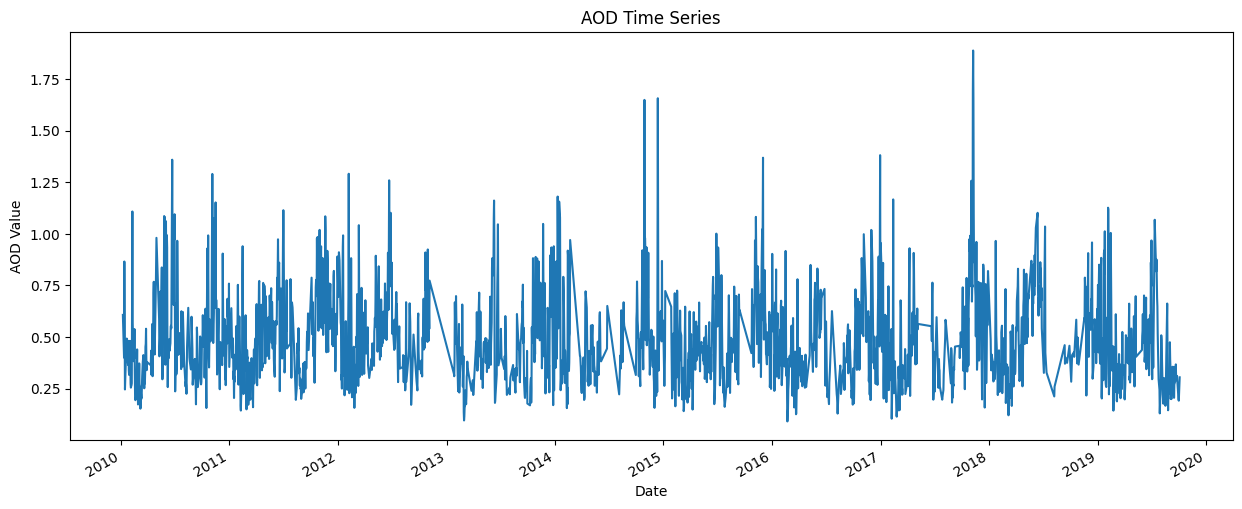

In [ ]:
plt.figure(figsize=(15, 6))
df['AOD'].plot(title='AOD Time Series')
plt.ylabel('AOD Value')
plt.show()

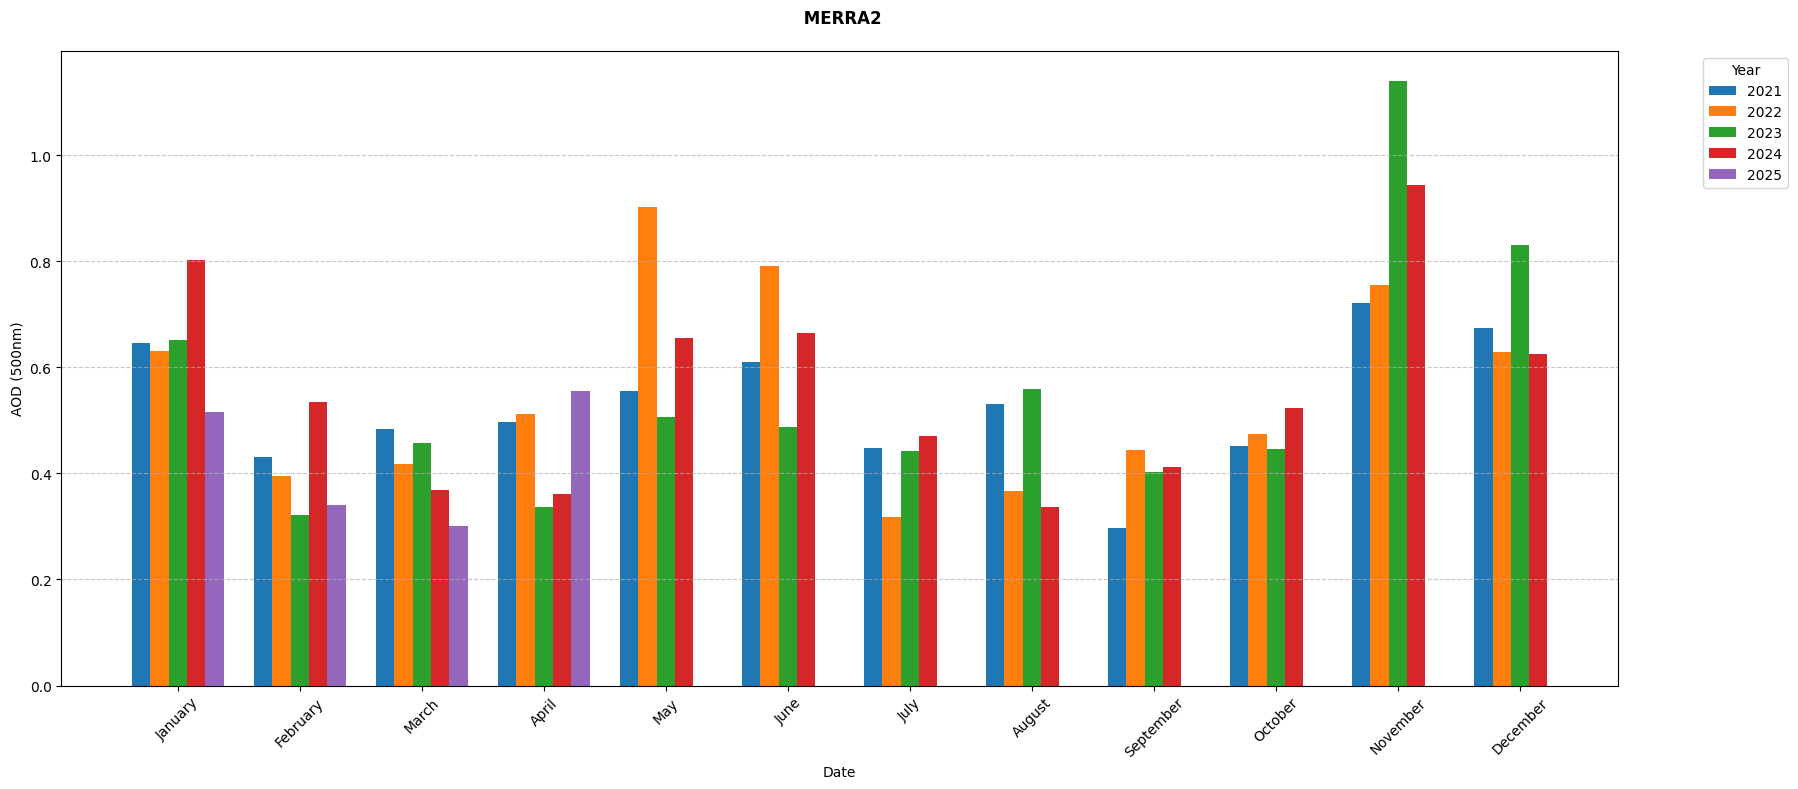

In [ ]:
sd_df = pd.read_excel('merra2(montly-kanpur).xlsx', sheet_name='g4.areaAvgTimeSeries.M2IMNXGAS_',skiprows=8)
sd_df['Date'] = pd.to_datetime(sd_df['time'])
sd_df = sd_df[(sd_df['Date'].dt.year >= 2021) & (sd_df['Date'].dt.year <= 2025)]

# Extract month and year
sd_df['Month'] = sd_df['Date'].dt.month_name()
sd_df['Year'] = sd_df['Date'].dt.year

# Pivot table for grouped bars
pivot_df = sd_df.pivot_table(index='Month', columns='Year', values='AOD_550nm', aggfunc='mean')

# Order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot_df = pivot_df.reindex(month_order)

# Plot
plt.figure(figsize=(18, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct colors for each year
width = 0.15  # Width of each bar

for i, year in enumerate(pivot_df.columns):
    positions = np.arange(len(pivot_df)) + i * width
    plt.bar(positions, pivot_df[year], width=width, label=year, color=colors[i])

plt.title(' MERRA2', fontweight='bold', pad=20)
plt.xlabel('Date')
plt.ylabel('AOD (500nm)')
plt.xticks(np.arange(len(pivot_df)) + width * 2, pivot_df.index, rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Outlier Detection and Removal

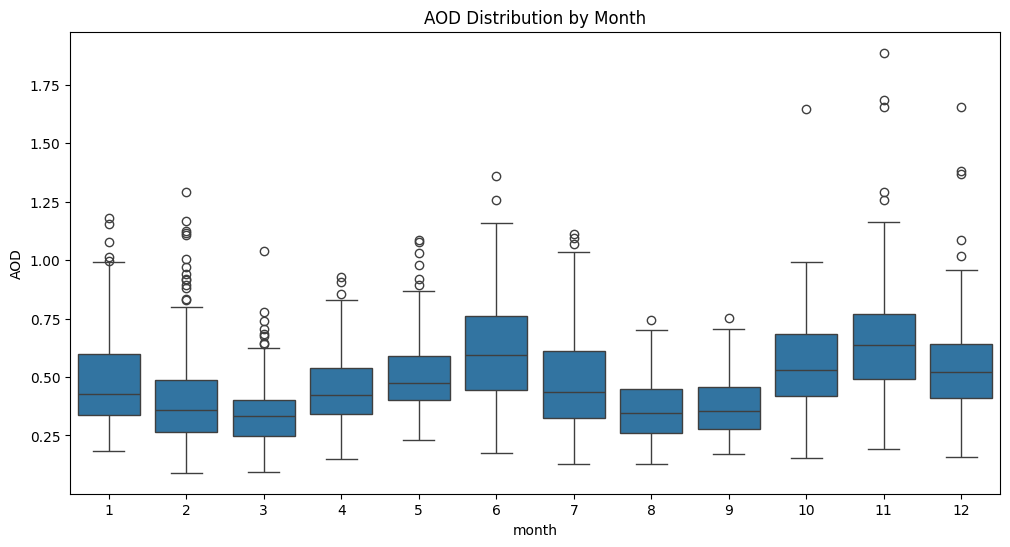

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='AOD', data=df)
plt.title('AOD Distribution by Month')
plt.show()

In [ ]:
z_scores = stats.zscore(df['AOD'])
abs_z_scores = np.abs(z_scores)
outliers = abs_z_scores > 3

In [ ]:
print(f"Number of outliers detected: {outliers.sum()}")

Number of outliers detected: 18


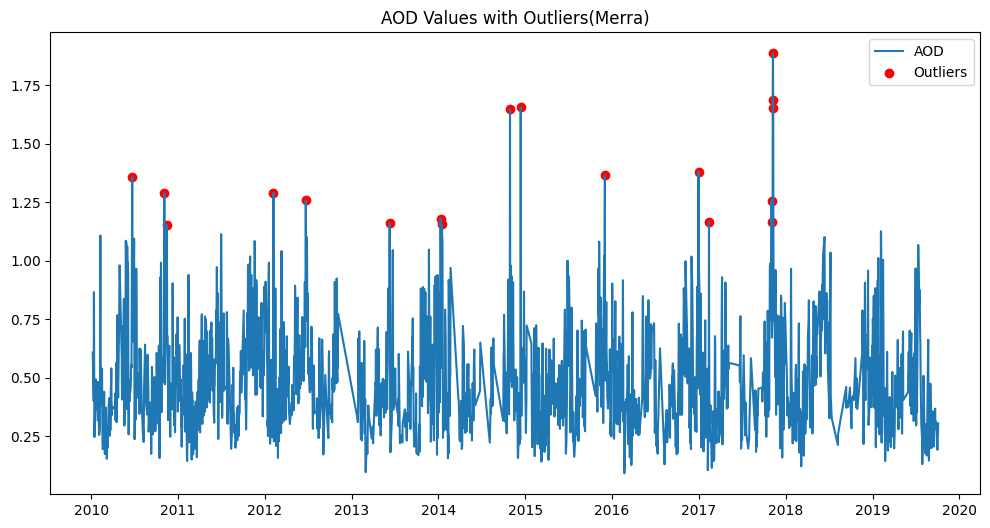

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AOD'], label='AOD')
plt.scatter(df.index[outliers], df['AOD'][outliers], color='red', label='Outliers')
plt.title('AOD Values with Outliers(Merra)')
plt.legend()
plt.show()

In [ ]:
mean_aod = df['AOD'].mean()
std_aod = df['AOD'].std()

In [ ]:
upper_bound = mean_aod + 3 * std_aod
lower_bound = mean_aod - 3 * std_aod

In [ ]:
df['AOD'] = df['AOD'].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
df.head()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2010-01-08,0.606755,2010,1,8,8,1,0.627044,0.537087,0.856710,0.736769,0.379535,0.636173,1.328404
2010-01-12,0.399666,2010,1,12,12,2,0.283133,0.406321,0.537087,0.481271,0.137440,0.594552,1.023497
2010-01-13,0.865408,2010,1,13,13,2,0.399666,0.419724,0.626254,0.515436,0.196516,0.600936,1.545134
2010-01-14,0.564481,2010,1,14,14,2,0.865408,0.283133,0.627044,0.506498,0.191964,0.590911,0.804563
2010-01-15,0.245490,2010,1,15,15,2,0.564481,0.399666,0.606755,0.454889,0.208379,0.560766,0.685251


In [ ]:
df.tail()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2019-09-24,0.308514,2019,9,24,267,39,0.281292,0.366996,0.435476,0.339147,0.080765,0.298453,0.351707
2019-09-25,0.311380,2019,9,25,268,39,0.308514,0.300999,0.511318,0.310584,0.027554,0.304009,0.299810
2019-09-30,0.197204,2019,9,30,273,40,0.162232,0.194535,0.281292,0.227013,0.064833,0.290425,0.172924
2019-10-01,0.191210,2019,10,1,274,40,0.197204,0.159828,0.308514,0.210255,0.054610,0.280990,0.768491
2019-10-04,0.304294,2019,10,4,277,40,0.224271,0.191210,0.194535,0.198872,0.052892,0.272423,0.358606


Feature Selection

In [ ]:
df.reset_index(inplace=True)

In [ ]:
X = df.drop(columns=[ 'AOD_550 nm','Date'])
y = df['AOD_550 nm']

In [ ]:
print(df['AOD_550 nm'].isnull().sum())

0


In [ ]:
print(df['AOD_550 nm'].isnull().sum())

0


In [ ]:
X

,index,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30
0,0,0.606755,2010,1,8,8,1,0.627044,0.537087,0.856710,0.736769,0.379535,0.636173
1,1,0.399666,2010,1,12,12,2,0.283133,0.406321,0.537087,0.481271,0.137440,0.594552
2,2,0.865408,2010,1,13,13,2,0.399666,0.419724,0.626254,0.515436,0.196516,0.600936
3,3,0.564481,2010,1,14,14,2,0.865408,0.283133,0.627044,0.506498,0.191964,0.590911
4,4,0.245490,2010,1,15,15,2,0.564481,0.399666,0.606755,0.454889,0.208379,0.560766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2416,0.308514,2019,9,24,267,39,0.281292,0.366996,0.435476,0.339147,0.080765,0.298453
2417,2417,0.311380,2019,9,25,268,39,0.308514,0.300999,0.511318,0.310584,0.027554,0.304009
2418,2418,0.197204,2019,9,30,273,40,0.162232,0.194535,0.281292,0.227013,0.064833,0.290425
2419,2419,0.191210,2019,10,1,274,40,0.197204,0.159828,0.308514,0.210255,0.054610,0.280990


In [ ]:
y

,AOD_550 nm
0,1.328404
1,1.023497
2,1.545134
3,0.804563
4,0.685251
...,...
2416,0.351707
2417,0.299810
2418,0.172924
2419,0.768491


Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
X_train.shape

(1936, 13)

In [ ]:
X_test.shape

(485, 13)

In [ ]:
y_train.shape

(1936,)

In [ ]:
y_test.shape

(485,)

Feature Scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[-1.73115638,  0.6264796 , -1.44641196, ...,  1.66776838,
         2.74444899,  1.38620125],
       [-1.72936708, -0.39524176, -1.44641196, ..., -0.01037171,
        -0.08840133,  1.00705365],
       [-1.72757777,  1.90261107, -1.44641196, ...,  0.21402705,
         0.60286016,  1.06520794],
       ...,
       [ 1.72757777,  2.428964  ,  1.5883883 , ...,  0.74057028,
         0.76945328,  0.37676278],
       [ 1.72936708,  2.44010125,  1.5883883 , ...,  1.29105376,
         0.99527792,  0.51404456],
       [ 1.73115638,  2.13785813,  1.5883883 , ...,  1.68491463,
         0.97316931,  0.67183681]])

In [ ]:
X_test_scaled

array([[ 1.73294569,  2.51930746,  1.5883883 , ...,  2.05819277,
         1.05256608,  0.81205578],
       [ 1.734735  ,  1.31367483,  1.5883883 , ...,  2.41899561,
        -0.01697062,  0.83277698],
       [ 1.73652431,  1.74330312,  1.5883883 , ...,  2.58873719,
        -0.34795467,  0.91158508],
       ...,
       [ 2.59539259, -1.39413732,  2.45547408, ..., -1.68036314,
        -0.9380115 , -1.76338599],
       [ 2.5971819 , -1.42371039,  2.45547408, ..., -1.79042917,
        -1.05763187, -1.84932845],
       [ 2.59897121, -0.86578269,  2.45547408, ..., -1.86519713,
        -1.07773298, -1.92736862]])

In [ ]:
y_train

,AOD_550 nm
0,1.328404
1,1.023497
2,1.545134
3,0.804563
4,0.685251
...,...
1931,0.719477
1932,0.790602
1933,1.377375
1934,1.091791


Model Training

Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor( n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42)

In [ ]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [ ]:
rf_pred = rf_model.predict(X_test_scaled)

In [ ]:
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = root_mean_squared_error(y_test, rf_pred)
rf_rmse=r2_score(y_test,rf_pred)

In [ ]:
print("\nRandom Forest Performance:")
print(f"MSE: {rf_mse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"RMSE: {rf_r2:.4f}")
print(f"R2:{rf_rmse:.4f}")


Random Forest Performance:
MSE: 0.0501
MAE: 0.1558
RMSE: 0.2238
R2:0.5415


Multi Layer Perceptron

In [ ]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    learning_rate_init=0.005,
    alpha=0.0001,
    batch_size=32,
    max_iter=5000,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

In [ ]:
mlp_model.fit(X_train_scaled, y_train)

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(100, 50),
             learning_rate_init=0.005, max_iter=5000, n_iter_no_change=20,
             random_state=42)

In [ ]:
mlp_pred = mlp_model.predict(X_test_scaled)

In [ ]:
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = root_mean_squared_error(y_test, mlp_pred)
mlp_rmse=r2_score(y_test,mlp_pred)

In [ ]:
print("\nMLP Performance:")
print(f"MSE: {mlp_mse:.4f}")
print(f"MAE: {mlp_mae:.4f}")
print(f"RMSE: {mlp_r2:.4f}")
print(f"R2:{mlp_rmse:.4f}")


MLP Performance:
MSE: 0.0503
MAE: 0.1644
RMSE: 0.2242
R2:0.5400


Long Short Term Memory(LSTM)

In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

In [ ]:
n_steps = 30
X_lstm, y_lstm = create_sequences(df['AOD_550 nm'].values, n_steps)

In [ ]:
split_idx = int(0.8 * len(X_lstm))
split_idx

1912

In [ ]:
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [ ]:
X_train_lstm.shape

(1912, 30)

In [ ]:
X_test_lstm.shape

(479, 30)

In [ ]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [ ]:
X_train_lstm.shape

(1912, 30, 1)

In [ ]:
X_test_lstm.shape

(479, 30, 1)

In [ ]:
lstm_model = Sequential([
    Input(shape=(n_steps, 1)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - loss: 0.1341 - val_loss: 0.0851
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 0.0866 - val_loss: 0.0854
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.0832 - val_loss: 0.0800
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - loss: 0.0801 - val_loss: 0.0800
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - loss: 0.0793 - val_loss: 0.0786
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - loss: 0.0854 - val_loss: 0.0798
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - loss: 0.0756 - val_loss: 0.0759
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.0823 - val_loss: 0.0742
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - loss: 0.0823 - val_loss: 0.0734
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0731 - val_loss: 0.0826
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.0748 - val_loss: 0.0747
Epoch 12/1

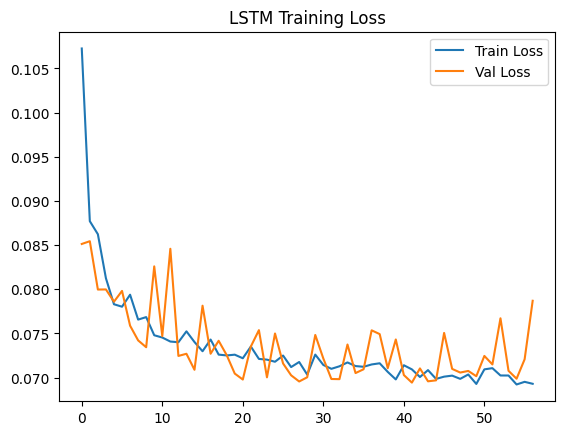

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


In [ ]:
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
lstm_r2 = root_mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_rmse=r2_score(y_test_lstm,y_pred_lstm)

In [ ]:
print("\nSimplified LSTM Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"RMSE: {lstm_r2:.4f}")
print(f"R2:{lstm_rmse:.4f}")


Simplified LSTM Performance:
MSE: 0.0694
MAE: 0.1869
RMSE: 0.2635
R2:0.3405


In [ ]:
plt.figure(figsize=(18, 10))

# Define common axis limits
all_actual = np.concatenate([y_test, y_test_lstm])
all_predicted = np.concatenate([rf_pred, mlp_pred, y_pred_lstm])
ax_min = min(all_actual.min(), all_predicted.min()) * 0.9
ax_max = max(all_actual.max(), all_predicted.max()) * 1.1

<Figure size 1800x1000 with 0 Axes>

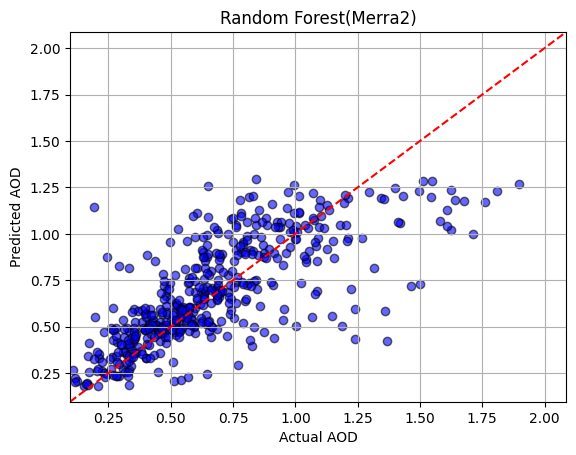

In [ ]:

plt.scatter(y_test, rf_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'Random Forest(Merra2)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

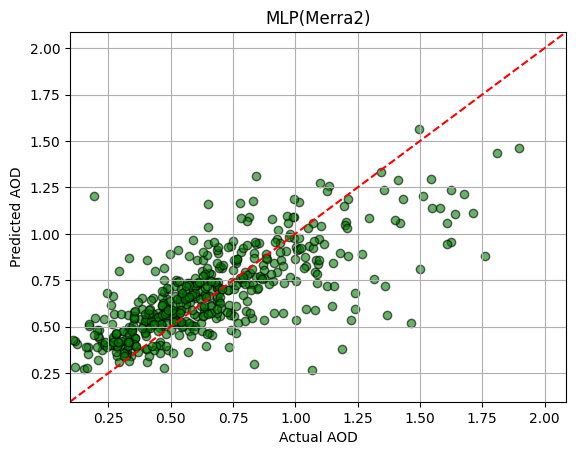

In [ ]:
plt.scatter(y_test, mlp_pred, alpha=0.6, color='green', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'MLP(Merra2)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

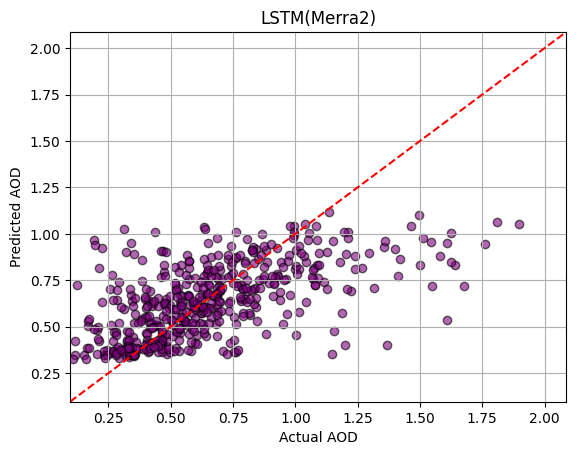

In [ ]:
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, color='purple', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'LSTM(Merra2)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

In [ ]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'MLP', 'LSTM'],
    'MSE': [rf_mse, mlp_mse, lstm_mse],
    'MAE': [rf_mae, mlp_mae, lstm_mae],
    'R²': [rf_r2, mlp_r2, lstm_r2]
})

In [ ]:
print("\nModel Comparison:")
print(model_comparison)
best_model_idx = np.argmin(model_comparison['MSE'])
best_model_name = model_comparison.loc[best_model_idx, 'Model']


Model Comparison:
           Model       MSE       MAE        R²
0  Random Forest  0.050104  0.155810  0.223839
1            MLP  0.050267  0.164406  0.224204
2           LSTM  0.069421  0.186913  0.263479


In [ ]:
aod_series.shape

(7425,)

In [ ]:
aod_series.index = pd.to_datetime(aod_series.index)

In [ ]:
aod_series = aod_series.asfreq('D').interpolate(method='time')

In [ ]:
n_days = 30
train = aod_series[:-n_days]
test = aod_series[-n_days:]

In [ ]:
model = ARIMA(aod_series, order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
forecast = model_fit.forecast(steps=n_days)

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

In [ ]:
print("\n📋 Forecast Table (Last 30 Days):")
print(forecast_df)


📋 Forecast Table (Last 30 Days):
            Actual_AOD  Forecasted_AOD
Date                                  
2025-04-02    0.334725        0.655472
2025-04-03    0.445788        0.593996
2025-04-04    0.358360        0.555455
2025-04-05    0.240364        0.531291
2025-04-06    0.232257        0.516143
2025-04-07    0.572162        0.506645
2025-04-08    0.712332        0.500691
2025-04-09    0.829523        0.496958
2025-04-10    1.086915        0.494617
2025-04-11    0.476278        0.493150
2025-04-12    0.605594        0.492230
2025-04-13    0.378327        0.491653
2025-04-14    0.526782        0.491292
2025-04-15    0.430280        0.491065
2025-04-16    0.383624        0.490923
2025-04-17    0.774342        0.490834
2025-04-18    0.514849        0.490778
2025-04-19    0.622670        0.490743
2025-04-20    0.437307        0.490721
2025-04-21    0.494438        0.490707
2025-04-22    0.270352        0.490699
2025-04-23    0.202701        0.490693
2025-04-24    0.255554        

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

In [ ]:
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 30),
                enforce_stationarity=False,
                enforce_invertibility=False)

In [ ]:
model_fit = model.fit(disp=False)

In [ ]:
forecast = model_fit.forecast(steps=n_days)

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

print("\n SARIMA Forecast Table:")
print(forecast_df.head(10))


 SARIMA Forecast Table:
            Actual_AOD  Forecasted_AOD
Date                                  
2025-04-02    0.334725        0.198680
2025-04-03    0.445788        0.223065
2025-04-04    0.358360        0.236481
2025-04-05    0.240364        0.235116
2025-04-06    0.232257        0.266964
2025-04-07    0.572162        0.265575
2025-04-08    0.712332        0.260438
2025-04-09    0.829523        0.267040
2025-04-10    1.086915        0.266224
2025-04-11    0.476278        0.277286
